# Transformers and Pipelines test on DatasetList object

In this notebook we check the `caits.transformers` and Sklearn Pipelines consisting of `caits.transformers`.

## Importing libraries

In [ ]:
import numpy as np
from caits.filtering import filter_butterworth
from caits.fe import mean_value, std_value, stft, melspectrogram, istft
from caits.dataset._dataset3 import CaitsArray, DatasetList
from caits.transformers._func_transformer_v2 import FunctionTransformer
from caits.transformers._feature_extractor_v2 import FeatureExtractor
from caits.transformers._func_transformer_2d_v2 import FunctionTransformer2D
from caits.transformers._feature_extractor_2d_v2 import FeatureExtractor2D
from sklearn.preprocessing import StandardScaler

## Dataset loading

For this notebook we will use the data/GestureSet_small dataset.

In [2]:
from caits.loading import csv_loader

data = csv_loader("data/GestureSet_small")


Loading CSV files: 100%|██████████| 924/924 [00:00<00:00, 1343.62it/s]


In [3]:
X, y, id = data["X"], data["y"], data["id"]
caitsX = [CaitsArray(values=x.values, axis_names={
    "axis_1": {
        col: i for i, col in enumerate(x.columns)
    }
}) for x in X]
type(caitsX[0]), type(y[0]), type(id[0])


(caits.dataset._dataset3.CaitsArray, str, str)

In [4]:
datasetListObj = DatasetList(caitsX, y, id)
datasetListObj

DatasetList object with 924 instances.

## FunctionTransformer

This transformer is mainly used for transforming the `X` attribute of the `DatasetList` object into a list of `CaitsArray`s with the shape maintained.

We test the `caits.transformer.FunctionTransformer` using the `caits.fe.filter_butterworth` function.

In [5]:
functionTransformer = FunctionTransformer(filter_butterworth, fs=200, filter_type='highpass', cutoff_freq=50)
transformedList = functionTransformer.fit_transform(datasetListObj)
transformedList

DatasetList object with 924 instances.

In [6]:
datasetListObj.X[0].values

array([[ 6.50000e-01,  2.27000e-01,  7.65000e-01, -4.82930e+01,
        -1.87800e+01, -1.81710e+01],
       [ 8.50000e-01,  1.75000e-01,  6.49000e-01, -5.06100e+01,
         1.28050e+01, -2.71340e+01],
       [ 9.80000e-01,  1.34000e-01,  5.07000e-01, -5.22560e+01,
         3.03660e+01, -3.03660e+01],
       ...,
       [ 1.34100e+00, -1.83000e-01,  3.20000e-02,  5.49000e-01,
        -3.39630e+01, -3.05490e+01],
       [ 1.69500e+00, -3.54000e-01,  6.90000e-02, -2.88410e+01,
        -1.09760e+01, -8.88410e+01],
       [ 1.96800e+00, -3.08000e-01,  3.09000e-01, -4.33540e+01,
         1.93900e+01, -1.17683e+02]])

In [7]:
transformedList.X[0].values

array([[ 2.01555385e-05,  4.32099118e-06,  7.11347027e-06,
        -4.32463718e-04, -5.96120657e-03, -1.31044886e-03],
       [ 1.41800834e-02,  8.64089925e-04,  8.72897031e-03,
        -3.88726942e-01, -1.54454591e-01,  4.51242898e-03],
       [-1.36048209e-02,  1.62356842e-03, -8.33764285e-03,
        -6.80272611e-03,  6.18062545e-01, -2.07246745e-01],
       ...,
       [-9.72889942e-03,  2.07514164e-02, -2.18143296e-03,
        -8.10518638e-01,  1.48724628e+00, -7.39856030e-02],
       [-2.62527203e-02, -4.09239682e-02, -2.93344000e-02,
         4.44577212e-01, -3.51790482e+00, -4.66535169e+00],
       [ 2.16568743e-04,  1.67545724e-04,  1.62162569e-04,
        -9.33721270e-03,  1.17002559e-02,  4.51638577e-03]])

## FeatureExtractor

This transformer is mainly used for extracting single values per column or per row (if axis=1) for each instance of `DatasetList.X`.

We test the `caits.transformer.FeatureExtractor` using the `caits.fe.mean_value` and `caits.fe.std_value`.

In [8]:
featureExtractor = FeatureExtractor([
    {
        "func": mean_value,
        "params": {}
    },
    {
        "func": std_value,
        "params": {
            "ddof": 0
        }
    }
])


In [9]:
tmp = featureExtractor.fit_transform(datasetListObj)
tmp

mean_value: [array([  0.96229187,  -0.02905263,   0.27272727,  -6.90569378,
       -11.1801244 ,   4.9378756 ]), array([  0.4625493 ,  -0.84834507,   0.19789437,   3.51723239,
       -19.44946479,   2.77916901]), array([ 1.69529412e-01,  6.03676471e-01,  6.59382353e-01, -2.87697059e+01,
       -2.36626647e+02, -2.71412941e+01]), array([ 0.93288636,  0.15657273,  0.15715909,  1.16965455, -3.73084545,
        1.06068636]), array([-0.30416129, -0.73704516,  0.60374194, -0.18252903, 11.4255871 ,
        0.43472903]), array([ 0.48533684,  0.71829474,  0.44598947, -1.33178947,  0.96785263,
       -1.67845263]), array([ 0.18170192,  0.826875  ,  0.558     , -6.08288462,  3.12325962,
        6.89614423]), array([  0.5765935 ,   0.43244715,   0.57720325, -11.06980488,
       -31.25666667,  -5.8943252 ]), array([  0.48984167,   0.551675  ,   0.595425  ,  -3.410575  ,
       -10.52238333,  -1.09198333]), array([ 0.46608911,  0.72357426,  0.49779208,  1.51717822, 15.29278218,
        0.53732673]),

DatasetList object with 924 instances.

## FeatureExtractor2D

This transformer is mainly used for extracting 2D features per column of each instance of `DatasetList.X`.

We test this using the `caits.fe.melspectrogram` and `caits.fe.stft`.
Applying each of these functions will transform each 2D `CaitsArray` of `DatasetList.X` into a 3D `CaitsArray`.

In [10]:
featureExtractor2D = FeatureExtractor2D(melspectrogram, n_fft=10, hop_length=10)
tmp = featureExtractor2D.fit_transform(datasetListObj)

/home/kirk/PycharmProjects/crossai-ts/caits/fe/_spectrum.py:127: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = mel_filter(sr=sr, n_fft=n_fft, **kwargs)


In [11]:
tmp

DatasetList object with 924 instances.

In [12]:
featureExtractor2D = FeatureExtractor2D(stft, n_fft=10, hop_length=10)
tmp = featureExtractor2D.fit_transform(datasetListObj)

In [13]:
tmp.X[900].values.shape

(6, 6, 7)

## FunctionTransformer2D

This is mainly used to inverse the `featureExtractor2D` process. So, if `DatasetList.X` is a list of 3D `CaitsArray` objects, it will be
transformed in a list of 2D `CaitsArray`.

To test this we use the `caits.fe.istft` on the transformed `DatasetList` object using `caits.fe.stft`.

In [14]:
functionTransformer = FunctionTransformer2D(istft, hop_length=10)
tmp = functionTransformer.fit_transform(tmp)

In [15]:
tmp.X[100].shape, datasetListObj.X[100].shape

((140, 6), (142, 6))

## SlidingWindow

This is used for performing the sliding window process in each instance of the `DatasetList` object.

The final windows will be appended in a single `DatasetList` object.

In [16]:
from caits.transformers._sliding_window_v2 import SlidingWindow

slidingWindow = SlidingWindow(window_size=10, overlap=5)
tmp = slidingWindow.fit_transform(datasetListObj)

In [17]:
len(tmp.X), len(tmp.y), len(tmp._id)

(25223, 25223, 25223)

## AugmentSignal

This is used for augmenting a `DatasetList` dataset, by processing the instances of the original dataset and appending them to a new `DatasetList` object.
This process can be repeated for a number of times, if desired.

As a use case, we add white noise and then performing time warping to each instance of the dataset after sliding window is performed. This process
is repeated two times, so if our original dataset has `N` instances, the resulting dataset will be consisting of `3*N` instances.

In [18]:
from caits.transformers._augment_singal import AugmentSignal
from caits.augmentation import add_noise_ts, time_warp_ts

augmentation_transformer = AugmentSignal(
    [
        {
            "func": time_warp_ts,
            "params": {
                "n_speed_change": 4
            }
        },
        {
            "func": add_noise_ts,
            "params": {
                "loc": 0,
                "scale": 1,
            }
        }
    ],
    repeats=2
)


In [19]:
augmented_tmp = augmentation_transformer.fit_transform(tmp)

In [20]:
tmp, augmented_tmp


(DatasetList object with 25223 instances.,
 DatasetList object with 75669 instances.)

In [21]:
len(tmp.X), len(tmp.y), len(tmp._id)


(25223, 25223, 25223)

In [22]:
len(augmented_tmp.X), len(augmented_tmp.y), len(augmented_tmp._id)


(75669, 75669, 75669)

In [23]:
tmp.X[0], augmented_tmp.X[0]


(   acc_x_axis_g  acc_y_axis_g  acc_z_axis_g  gyr_x_axis_deg/s  gyr_y_axis_deg/s  gyr_z_axis_deg/s  
 0          0.65         0.227         0.765           -48.293            -18.78           -18.171  
 1          0.85         0.175         0.649            -50.61            12.805           -27.134  
 2          0.98         0.134         0.507           -52.256            30.366           -30.366  
 3         1.118         0.101         0.406           -53.293            25.854             -25.0  
 4         1.243          0.09         0.356           -54.695              6.22           -14.268  
 5         1.297         0.084         0.371           -51.646           -21.159             0.915  
 6         1.315         0.065         0.477           -47.012           -53.476            18.415  
 7         1.312         0.083         0.612           -41.646           -82.622             36.22  
 8         1.167         0.101         0.711           -36.098           -99.939           

In [24]:
augmented_tmp.X[0], augmented_tmp.X[20178]


(   acc_x_axis_g  acc_y_axis_g  acc_z_axis_g  gyr_x_axis_deg/s  gyr_y_axis_deg/s  gyr_z_axis_deg/s  
 0          0.65         0.227         0.765           -48.293            -18.78           -18.171  
 1          0.85         0.175         0.649            -50.61            12.805           -27.134  
 2          0.98         0.134         0.507           -52.256            30.366           -30.366  
 3         1.118         0.101         0.406           -53.293            25.854             -25.0  
 4         1.243          0.09         0.356           -54.695              6.22           -14.268  
 5         1.297         0.084         0.371           -51.646           -21.159             0.915  
 6         1.315         0.065         0.477           -47.012           -53.476            18.415  
 7         1.312         0.083         0.612           -41.646           -82.622             36.22  
 8         1.167         0.101         0.711           -36.098           -99.939           

## DatasetToArray

This is used for transforming `DatasetList.X` attribute to a single `np.array`.

In this case, each window will be flattened and then all windows will be stacked in a single `np.array`, where each row is a
flattened window.

In [25]:
from caits.transformers._data_converters_v2 import DatasetToArray

dataFlatten = DatasetToArray(flatten=True, dtype=np.float64)

dataFlatten.fit(tmp)


DatasetToArray(dtype=<class 'numpy.float64'>, flatten=True)

In [26]:
tmp_conv = dataFlatten.transform(tmp)
tmp_conv

DatasetList object with 25223 instances.

In [27]:
tmp_conv.X

            0       1      2        3        4        5  \
    0    0.65   0.227  0.765  -48.293   -18.78  -18.171  
    1   1.297   0.084  0.371  -51.646  -21.159    0.915  
    2   1.003   0.145  0.685  -17.256  -99.207   60.549  
    3    0.22    0.27  0.234   -2.134   15.244    7.683  
    4   1.211  -0.034  0.565  -20.793  -61.585  -17.744  
  ...     ...     ...    ...      ...      ...      ...  
25218  -0.482  -0.773  0.492    -1.22  -37.012    4.817  
25219  -0.422  -0.764  0.415   -1.646  -41.951   12.073  
25220  -0.465  -0.777  0.471   -2.012  -42.378   14.817  
25221  -0.385  -0.728  0.515   -2.561   -33.11   26.098  
25222  -0.336  -0.667   0.62   -2.439  -37.683   54.817  

            6       7      8        9       10       11  \
    0    0.85   0.175  0.649   -50.61   12.805  -27.134  
    1   1.315   0.065  0.477  -47.012  -53.476   18.415  
    2   0.804   0.181  0.623   -9.024  -80.305   56.098  
    3   0.254   0.237  0.218   -4.756    0.671   -4.634  
    4    1.

## ArrayToDataset

This is mainly used to transform `DatasetList.X`, which is a single `np.array` in a list of `CaitsArrays` reshaped.

In this case we inverse the previous step, taking each flattened window (row of the `CaitsArray) and transforming it
in a 2D `CaitsArray`, and then placing them in a list.

In [28]:
from caits.transformers._data_converters_v2 import ArrayToDataset

shape = tmp.X[0].shape

dataInverseFlatten = ArrayToDataset(
    shape=shape,
    dtype=np.float64,
    axis_names={"axis_1": tmp.X[0].axis_names["axis_1"]}
)

dataInverseFlatten.fit(tmp_conv)

tmp_conv_inv = dataInverseFlatten.transform(tmp_conv)


In [29]:
tmp_conv_inv.X[0]


   acc_x_axis_g  acc_y_axis_g  acc_z_axis_g  gyr_x_axis_deg/s  gyr_y_axis_deg/s  gyr_z_axis_deg/s  
0          0.65         0.227         0.765           -48.293            -18.78           -18.171  
1          0.85         0.175         0.649            -50.61            12.805           -27.134  
2          0.98         0.134         0.507           -52.256            30.366           -30.366  
3         1.118         0.101         0.406           -53.293            25.854             -25.0  
4         1.243          0.09         0.356           -54.695              6.22           -14.268  
5         1.297         0.084         0.371           -51.646           -21.159             0.915  
6         1.315         0.065         0.477           -47.012           -53.476            18.415  
7         1.312         0.083         0.612           -41.646           -82.622             36.22  
8         1.167         0.101         0.711           -36.098           -99.939            51.098  


## SklearnWrapper

This is mainly used to wrap various `sklearn.transformers` in a way where they internally process a `np.array`, but by
always inserting and returning a `DatasetList` object. This is a necessary concept for using `sklearn` capabilities, without
losing the structure and attributes of the various `DatasetList` objects.

In this case, we test this using `sklearn.preprocesssing.StandardScaler` on the flattened `DatasetList` object.

In [30]:
from caits.transformers._sklearn_wrapper import SklearnWrapper
scaler = SklearnWrapper(StandardScaler)

tmp_flat_scaled = scaler.fit_transform(tmp_conv)

In [31]:
scaler.fitted_transformer_.mean_.shape, scaler.fitted_transformer_.var_.shape

((60,), (60,))

In [32]:
# tmp_flat_scaled.X[0].shape, len(tmp_flat_scaled.y), len(tmp_flat_scaled._id)
tmp_flat_scaled.X

                          0                     1                     2                      3                     4                     5  \
    0    0.9579952891487599   -0.4296959147990568    0.8311960675293498    -1.6293774259893985  -0.17884054824749038  -0.37450881718299317  
    1    1.8604920480664369   -0.6327993249567408  -0.02207282206154568     -1.744961598879451  -0.20194890567365328   0.11389415114692919  
    2    1.4503930571517583   -0.5461608073370294    0.6579435011149549    -0.5594740636307491   -0.9600662156346301    1.6399039286480603  
    3    0.3581906425728692  -0.36862286139499784   -0.3187678420461971  -0.038190478052648934   0.15165073088986458   0.28708451527020873  
    4    1.7405311187512589   -0.8003951459260187    0.3980646514933621    -0.6814010602045978   -0.5946258528405565  -0.36358206105405694  
  ...                   ...                   ...                   ...                    ...                   ...                   ...  
25218    -0.

## Pipelines

In this subsection we will test the `sklearn.pipeline.Pipeline` using the `caits.transformer`s.



### Use case 1

1) the original `DatasetList` object is split into train and test parts
2) a pipeline is constructed that performs flattening, standard scaling and unflattening
3) the train set is fit in the pipeline and transformed
4) the test set is transformed using this pipeline


In [33]:
tmp_train, tmp_test, = tmp.train_test_split(random_state=42)
tmp_train, tmp_test, type(tmp_train.X[0]), type(tmp_test.X[0])

(DatasetList object with 20178 instances.,
 DatasetList object with 5045 instances.,
 caits.dataset._dataset3.CaitsArray,
 caits.dataset._dataset3.CaitsArray)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

pipeline = Pipeline(
    [
        ("conv", dataFlatten),
        ("scaler", scaler),
        ("conv_inv", dataInverseFlatten),
    ]
)

In [35]:
pipeline.fit(tmp_train)

Pipeline(steps=[('conv',
                 DatasetToArray(dtype=<class 'numpy.float64'>, flatten=True)),
                ('scaler',
                 SklearnWrapper(transformer=<class 'sklearn.preprocessing._data.StandardScaler'>,
                                transformer_kwargs={})),
                ('conv_inv',
                 ArrayToDataset(axis_names={'axis_1': {'acc_x_axis_g': 0,
                                                       'acc_y_axis_g': 1,
                                                       'acc_z_axis_g': 2,
                                                       'gyr_x_axis_deg/s': 3,
                                                       'gyr_y_axis_deg/s': 4,
                                                       'gyr_z_axis_deg/s': 5}},
                                axis_names_={'axis_1': {'acc_x_axis_g': 0,
                                                        'acc_y_axis_g': 1,
                                                        'acc_z_axis_g': 2,
                                                        'gyr_x_axis_deg/s': 3,
                                                        'gyr_y_axis_deg/s': 4,
                                                        'gyr_z_axis_deg/s': 5}},
                                dtype=<class 'numpy.float64'>,
                                dtype_=<class 'numpy.float64'>, shape=(10, 6),
                                shape_=(10, 6)))])

In [36]:
pipeline.named_steps["scaler"].fitted_transformer_.mean_

array([-0.03527817,  0.5280725 ,  0.38032635, -0.97728898, -0.57514625,
       -3.45386956, -0.03547145,  0.52826797,  0.37967876, -0.90655278,
       -0.80213901, -3.65123759, -0.0363034 ,  0.52814199,  0.37965467,
       -0.83668669, -1.06183323, -3.82393736, -0.03646556,  0.52792636,
        0.38012345, -0.79006413, -1.23157171, -3.95490237, -0.03666017,
        0.52826955,  0.38097725, -0.72855977, -1.29181361, -4.04847349,
       -0.03721023,  0.5281517 ,  0.38120954, -0.64606358, -1.36416548,
       -4.16357042, -0.03811156,  0.52771122,  0.38073159, -0.6126122 ,
       -1.54238765, -4.30362405, -0.03959054,  0.52734166,  0.38045911,
       -0.6294719 , -1.73990445, -4.42406135, -0.03970354,  0.52673471,
        0.3802586 , -0.68320433, -1.84099737, -4.51443652, -0.03910482,
        0.52676896,  0.37993701, -0.7049997 , -1.84412752, -4.61656368])

In [37]:
final_train = pipeline.fit_transform(tmp_train)
final_test = pipeline.transform(tmp_test)

In [38]:
final_train, final_test

(DatasetList object with 20178 instances.,
 DatasetList object with 5045 instances.)

In [39]:
final_train.X[0].shape, final_test.X[0].shape

((10, 6), (10, 6))

In [40]:
len(final_train.y), len(final_test.y)

(20178, 5045)

In [41]:
print(pipeline.named_steps['scaler'].fitted_transformer_.mean_.shape)
print(pipeline.named_steps['scaler'].fitted_transformer_.var_.shape)


(60,)
(60,)


In [42]:
tmp_train.X[0]

   acc_x_axis_g  acc_y_axis_g  acc_z_axis_g  gyr_x_axis_deg/s  gyr_y_axis_deg/s  gyr_z_axis_deg/s  
0        -0.039         0.862          0.43             1.707            69.878            -6.037  
1        -0.013          0.86         0.419             -0.61            64.939            -6.524  
2         0.039         0.864         0.327            -2.744            52.805            -7.439  
3         0.033         0.859         0.251            -3.598            41.585            -8.476  
4        -0.056         0.832          0.25            -2.073            36.707            -8.659  
5        -0.177           0.8         0.292             1.341            37.256            -8.049  
6        -0.215         0.766         0.341             6.768             40.61            -8.841  
7        -0.163         0.733         0.371            12.073            42.378           -12.561  
8        -0.089         0.699          0.35            16.037            39.207           -16.463  


In [43]:
final_train.X[0]

            acc_x_axis_g         acc_y_axis_g           acc_z_axis_g      gyr_x_axis_deg/s     gyr_y_axis_deg/s      gyr_z_axis_deg/s  
0  -0.005185043671110938  0.47047678561463224      0.107361385865385   0.09419640460052082   0.6789043966361139  -0.06607574186439628  
1    0.03136755680867366   0.4657508553331304    0.08520786143273344   0.01039614349170052   0.6330440864555087  -0.07356233897992263  
2    0.10521152625794285   0.4708818475717814   -0.11421732775296636  -0.06684392230530857   0.5184193087065799  -0.09270558758685248  
3    0.09721259570442967  0.46481705157616815    -0.2803700004386542  -0.09801507418952567   0.4119038974720174  -0.11606514971291729  
4  -0.027075905891452305  0.42700603093708733   -0.28477361399555984  -0.04688163610629338   0.3656852875943915  -0.11837546393124113  
5   -0.19531169020043068  0.38238943091658417   -0.19468572643218332   0.06925496844483049   0.3719099481946017  -0.09961326680572177  
6   -0.24732483979205652   0.3346718845782153   

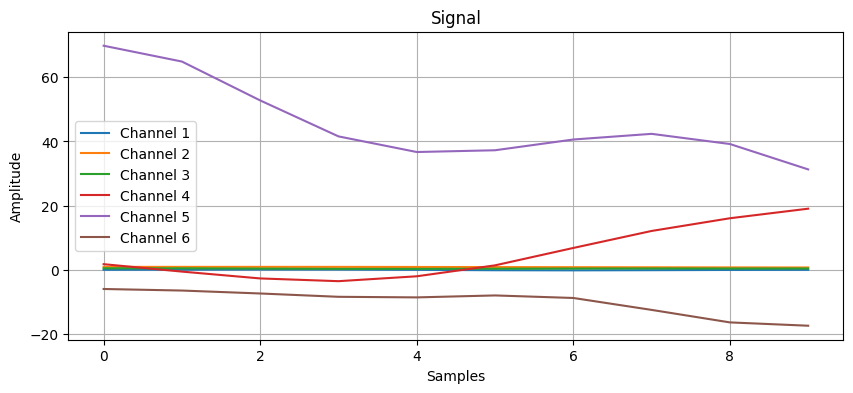

In [44]:
from caits.visualization import plot_signal

plot_signal(tmp_train.X[0].values, return_mode=False)

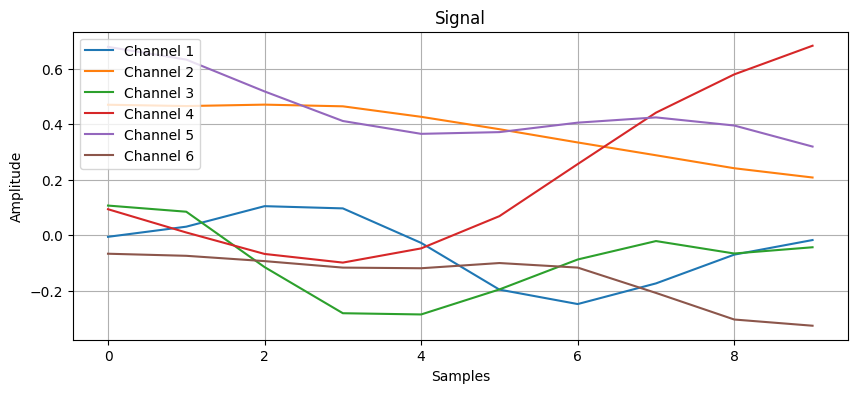

In [45]:
plot_signal(final_train.X[0].values, return_mode=False)


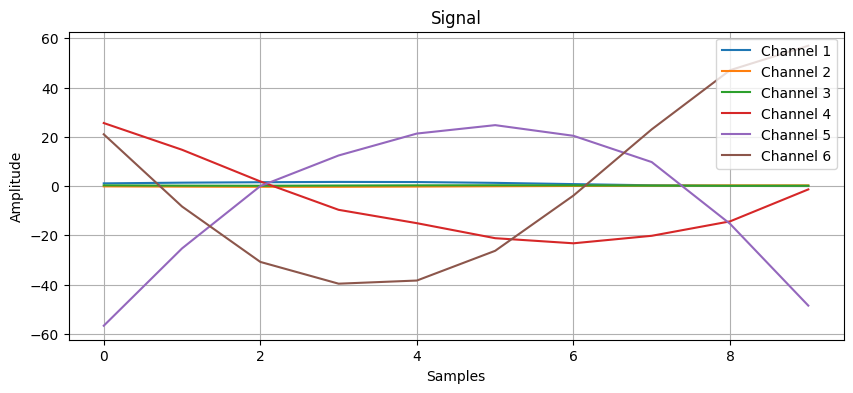

In [46]:
plot_signal(tmp_test.X[0].values, return_mode=False)


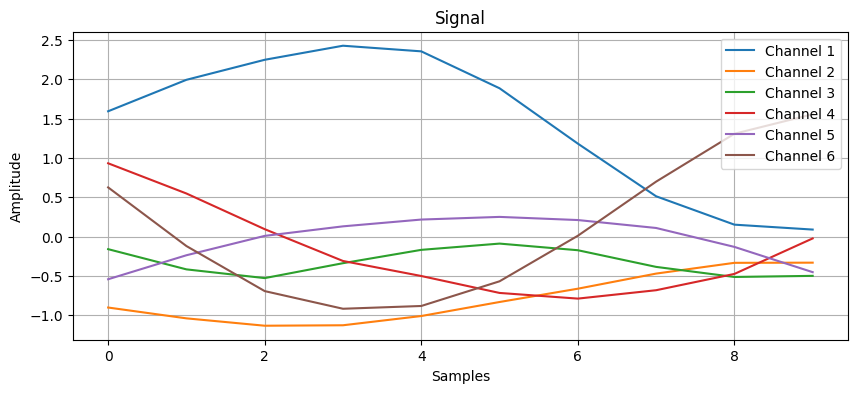

In [47]:
plot_signal(final_test.X[0].values, return_mode=False)


### Use Case 2

1) the original `DatasetList` object is split into train and test parts (already done before)
2) a pipeline is constructed that performs flattening, standard scaling and PCA
3) the train set is fit in the pipeline and transformed
4) the test set is transformed using this pipeline


In [48]:
from sklearn.decomposition import PCA

pipeline2 = Pipeline(
    [
        ("conv", dataFlatten),
        ("scaler", SklearnWrapper(StandardScaler)),
        ("pca", SklearnWrapper(PCA, {"n_components": 2})),
    ]
)

tmp_pca_train = pipeline2.fit_transform(tmp_train)
tmp_pca_test = pipeline2.transform(tmp_test)

In [49]:
tmp_pca_train, tmp_pca_test, tmp_pca_train.X.shape, tmp_pca_test.X.shape

(DatasetList object with 20178 instances.,
 DatasetList object with 5045 instances.,
 (20178, 2),
 (5045, 2))

In [50]:
def plot_scatter_pca(
        arr: np.ndarray,
        c_name: str="y",
        cmap_set: str = "plasma"

):
    import matplotlib.pyplot as plt

    if arr.ndim == 2:
        plt.style.use('classic')
        plt.figure(figsize=(16, 8))
        plt.scatter(arr[:, 0], arr[:, 1], c=c_name, cmap=cmap_set)
        plt.xlabel('First principal component')
        plt.ylabel('Second Principal Component')

    elif arr.ndim == 3:
        plt.style.use('classic')
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(arr[:, 0], arr[:, 1], arr[:, 2], c=c_name, cmap=cmap_set)
        ax.set_xlabel('First principal component')
        ax.set_ylabel('Second Principal Component')
        ax.set_zlabel('Third Principal Component')

    else:
        print("The DataFrame has more than 4 columns.")


/tmp/ipykernel_30973/927769962.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(arr[:, 0], arr[:, 1], c=c_name, cmap=cmap_set)


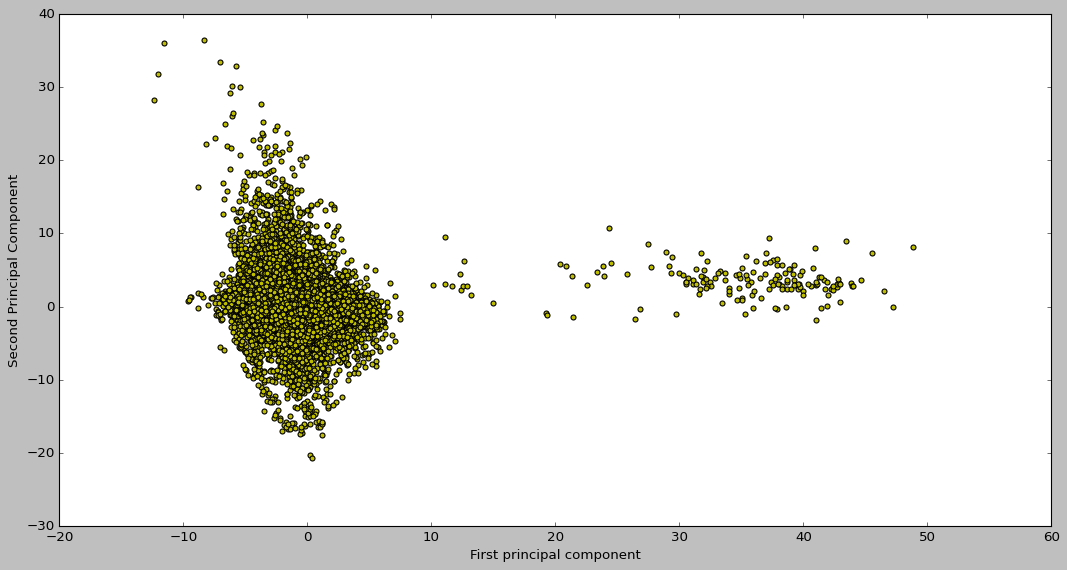

In [51]:
plot_scatter_pca(tmp_pca_train.X.values, cmap_set="viridis")

/tmp/ipykernel_30973/927769962.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(arr[:, 0], arr[:, 1], c=c_name, cmap=cmap_set)


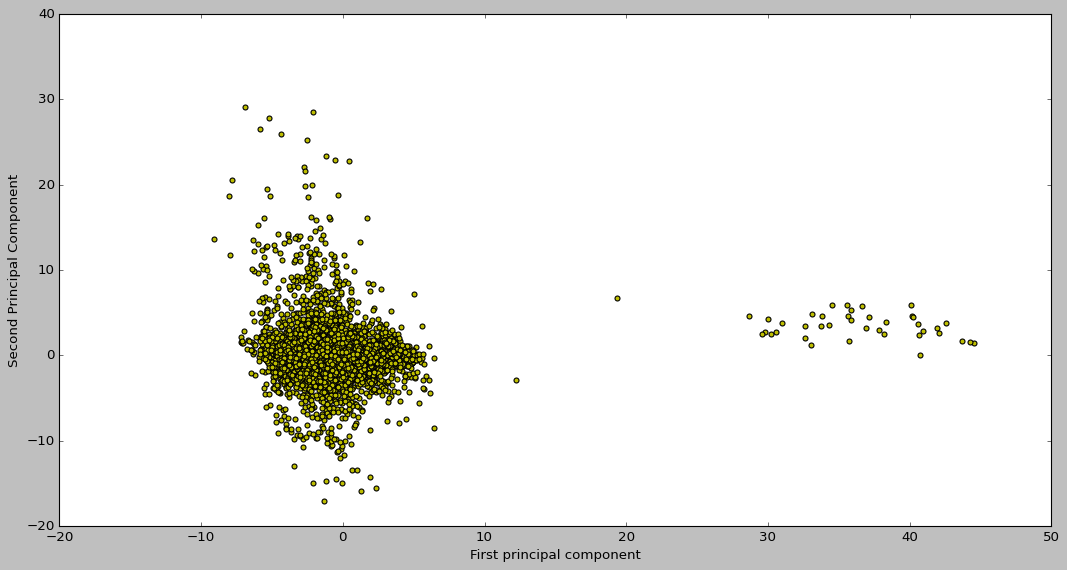

In [52]:
plot_scatter_pca(tmp_pca_test.X.values, cmap_set="viridis")

### Use Case 3

1) the original `DatasetList` object is split into train and test parts (already done before)
2) a pipeline is constructed that performs flattening, normalization, quantile transform and unflattening.
3) the train set is fit in the pipeline and transformed
4) the test set is transformed using this pipeline


In [53]:
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer

# kwargs_dict = {
#     "output_distribution": "uniform",
#     "n_quantiles": 100
# }

pipe_sklearn = Pipeline(
    [
        ("flatten", dataFlatten),
        ("scaler", SklearnWrapper(MinMaxScaler)),
        ("quantile", SklearnWrapper(QuantileTransformer, {"output_distribution": "uniform", "n_quantiles": 100})),
        # ("quantile", SklearnWrapper(QuantileTransformer, **kwargs_dict)),
        # ("pca", SklearnWrapper(PCA, n_components=2)),
        ("unflatten", dataInverseFlatten)
    ]
)

In [54]:
train = pipe_sklearn.fit_transform(tmp_train)
test = pipe_sklearn.transform(tmp_test)

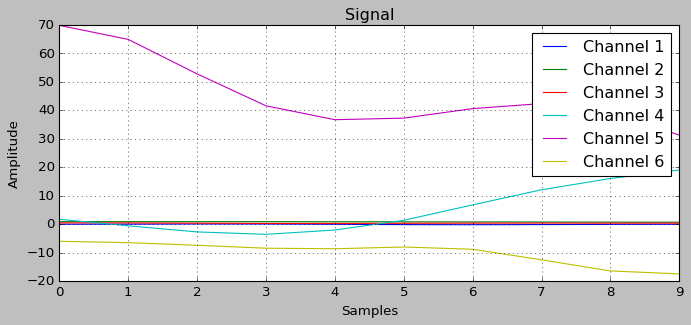

In [55]:
plot_signal(tmp_train.X[0].values, return_mode=False)

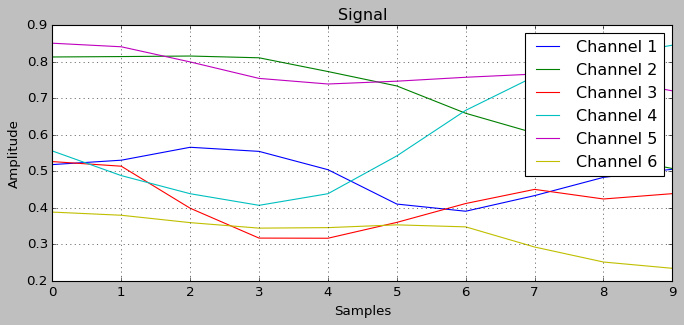

In [56]:
plot_signal(train.X[0].values, return_mode=False)

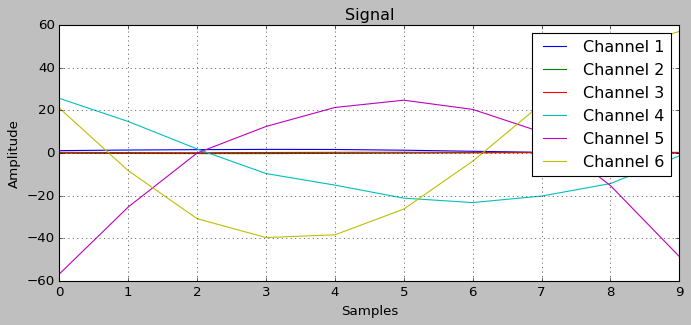

In [57]:
plot_signal(tmp_test.X[0].values, return_mode=False)

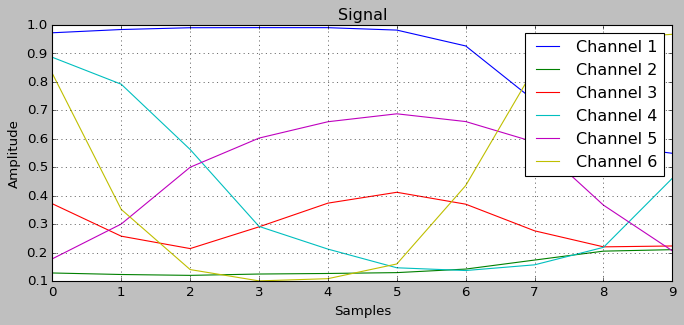

In [58]:
plot_signal(test.X[0].values, return_mode=False)